Final Grade: 50/50

# IST 718 Project Group 4:
* Trishla Jain 
* Eric R. Pfeiffer
* Kyle McGee
* David A. Garcia

The dataset used for this project was retrieved from the following Kaggle page:
[Data Science and STEM Salaries](https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries). The dataset does not need to be downloaded in order to run this notebook.

# Import Libraries

In [ ]:
# install spark
!pip install pyspark &> /dev/nullv
!pip install pyecharts==1.7.1 &> /dev/null

In [ ]:
# import spark libraries
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# build spark session
spark = SparkSession.builder.getOrCreate()
spark_context = spark.sparkContext
sqlContext = SQLContext(spark_context)

# import pyspark SQL functions
from pyspark.sql import functions as fn, Row
from pyspark.sql.functions import when, isnan, isnull, count 
from pyspark.sql.functions import col, row_number, desc
from pyspark.sql.functions import regexp_replace, expr
from pyspark.sql.window import Window
from pyspark.sql.types import DecimalType

# import pyspark machine learning 
from pyspark.ml import feature, Pipeline, classification, regression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
from pyspark.ml import clustering
from pyspark.ml.feature import StringIndexer, VectorAssembler

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# libraries for Maps
!pip install geopandas &> /dev/nullv
!pip install folium &> /dev/nullv
import geopandas
import folium

In [ ]:
# import utility libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
%%bash

# Download the data files from github
# If the data file does not exist in the colab environment
data_file_1=Levels_Fyi_Salary_Data.csv

if [[ ! -f ./${data_file_1} ]]; then
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/trishh088/Levels-FYI-Salary-Data/main/${data_file_1} &> /dev/null
fi

In [ ]:
# function to return the shape of a spark dataframe as 
# (number of rows, number of columns)
def spark_shape(self): 
  return (self.count(), len(self.columns))

In [ ]:
enable_grid = False

# Dataframe Cleaning

In [ ]:
#Import the data 
salary_df = spark.read.format("csv").option("header", "true").load("Levels_Fyi_Salary_Data.csv")

In [ ]:
#Keep variables to be used
salary_df_cleaned = salary_df.select("timestamp", "company", "title", "basesalary",
                            "stockgrantvalue", "bonus", "totalyearlycompensation",
                            "location", "yearsofexperience", "yearsatcompany",
                            "gender", "Race", "Education")

#Select columns to change the type
cols_to_int = ["basesalary", "stockgrantvalue", "bonus", 
               "totalyearlycompensation", "yearsofexperience", "yearsatcompany"]

#Change type from string to integer
for col_name in cols_to_int:
    salary_df_cleaned = salary_df_cleaned.withColumn(col_name, col(col_name).cast('int'))

# dropping rows where the job title doesn't make sense
salary_df_cleaned = salary_df_cleaned.where((~col("title").like("99%") & ~col("title").like("%SE1%")))

# dropping rows where the job title is null
salary_df_cleaned = salary_df_cleaned.filter(salary_df_cleaned.title.isNotNull())

# remove all hard coded NA's in the gender, race, and education column
salary_df_cleaned = salary_df_cleaned.filter(((salary_df_cleaned.gender != "NA") & (salary_df_cleaned.Race != "NA") & (salary_df_cleaned.Education != "NA")))

# remove instances where the race column is equal to 0 or 1 
salary_df_cleaned = salary_df_cleaned.filter(salary_df_cleaned.Race != "0")
salary_df_cleaned = salary_df_cleaned.filter(salary_df_cleaned.Race != "1")

# remove instances where the education colum is equal to 0 
salary_df_cleaned = salary_df_cleaned.filter(salary_df_cleaned.Education != "0")

# create city, state, and country columns
salary_df_cleaned = salary_df_cleaned.withColumn("city", fn.split(salary_df_cleaned["location"], ", ").getItem(0)).\
                    withColumn("state", fn.split(salary_df_cleaned["location"], ", ").getItem(1)).\
                    withColumn("country", fn.split(salary_df_cleaned["location"], ", ").getItem(2))

# replace null values in country column 
salary_df_cleaned = salary_df_cleaned.withColumn("country", fn.when((fn.col("city")=="Tel Aviv") & (fn.col('state')=='Israel'),'Israel').\
                                                         when(fn.isnull(fn.col('country')),'United States of America').\
                                                         when(fn.col('country')=='United States','United States of America').\
                                                         when(fn.col('country')=='Burma','Myanmar').\
                                                         when(fn.col('country')=='Czech Republic','Czechia').\
                                                         when(fn.col('country')=='Hong Kong (SAR)','China').\
                                                         when(fn.col('country')=='Korea','South Korea').\
                                                         otherwise(fn.col('country')))

# clean timestamp, generate year column, and stratify between 'before' and 'after' pandemic
salary_df_cleaned = salary_df_cleaned.withColumn('date',fn.expr("trim(substring(timestamp, 0, length(timestamp)-8))")).\
                                      withColumn('year',fn.expr("substring(date, length(date)-3,4)").cast('int')).\
                                      withColumn('post_pandemic_id',fn.when(fn.col('year')<2020,fn.lit(0)).otherwise(fn.lit(1)))

## Standardizing Company Names

In [ ]:
# function to find company names to clean, intentionally hashed to avoid long running process

# company_names = distinct_company_names.select("Company_Lowercase").rdd.flatMap(lambda x: x).collect()

# company_names_dict = {}
# from pyspark.sql.functions import expr
# for row in distinct_company_names.collect():
#   for name in company_names:
#     r = re.compile(r'.*({}).*'.format(name))
#     # r = re.compile(r'.*(the climate corporation).*')
#     if r.match(row.Company_Lowercase):
#       company_names_dict[name] = row.Company_Lowercase
#     else:
#       pass
# company_names_dict
# import operator
# sorted(company_names_dict.items(), key=operator.itemgetter(1))
# sorted(company_names_dict.items(), key=operator.itemgetter(0))


# cleaning the company names column to match the correct company name

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Akamai Technologies', 'Akamai'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Amazon Web Services', 'AWS'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Aruba Networks', 'Aruba'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Bain', 'Bain & Company'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Bank of America Merrill Lynch', 'Bank of America'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'BCG Digital Ventures', 'BCG'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Bloomberg LP', 'Bloomberg'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Booking.com', 'Booking'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Bosch Global", "Bosch"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "CACI International", "CACI"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Cadence Design Systems", "Cadence"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Cgi group', 'CGI Group'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'CGI Group', 'CGI'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'cisco systems', 'Cisco'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'cisco', 'Cisco'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Cisco Systems', 'Cisco'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Cisco Meraki', 'Cisco'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Citibank', 'Citi'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Cognizant Technology Solutions',
                                   'Cognizant'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Costco Wholesale', 'Costco'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Cox Automotive', 'Cox Enterprises'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Deloitte Advisory', 'Deloitte'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Deloitte Consulting', 'Deloitte'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Discover Financial Services', 'Discover'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Dish Network', 'DISH Network'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'DISH Network', 'DISH'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'DISH', 'DISH Network'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'The Walt Disney Company', 'Disney'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'EPAM Systems', 'EPAM'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'EPAM', 'EPAM Systems'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Ernst and Young', 'Ernst & Young'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'EY', 'Ernst & Young'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Expedia Group', 'Expedia'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Expedia', 'Expedia Group'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Ford Motor Company', 'Ford Motor'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Ford Motor', 'Ford'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Ford', 'Ford Motor Company'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'GOJEK', 'Gojek'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Gojek Tech', 'Gojek'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Google LLC', 'Google'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Here', 'HERE'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'HERE Technologies', 'HERE'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'HERE', 'HERE Technologies'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'HP inc', 'HP Inc'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'HP Inc', 'HP INC'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'HP INC', 'HP'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'HPE', 'Hewlett Packard Enterprise'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Infosys Ltd', 'Infosys'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Intel Corporation', 'Intel'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Johnson and Johnson', 'Johnson'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Johnson & Johnson', 'Johnson'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Johnson', 'Johnson & Johnson'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'JP Morgan Chase', 'JP Morgan'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'jp morgan', 'JP Morgan'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Jp Morgan', 'JP Morgan'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'JP Morgan', 'JP Morgan Chase'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'JPMorgan Chase', 'JP Morgan Chase'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'JP Morgan Chase', 'JPMorgan Chase'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'JPMorgan Chase', 'Chase'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'JPMorgan', 'Chase'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'JPMORGAN', 'Chase'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Chase', 'JPMorgan Chase'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', 'Liberty Mutual', 'Liberty Mutual Insurance'))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "lowes", "Lowe\'s"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Lowes", "Lowe\'s"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "McKinsey", "McKinsey & Company"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Microchip Technology", "Microchip"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Microchip", "Microchip Technology"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "microsoft corporation", "Microsoft"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Microsoft Corporation", "Microsoft"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Microsoft", "Microsoft Corporation"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "MICROSOFT", "Microsoft Corporation"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Nuance Communications", "Nuance"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Nuance", "Nuance Communications"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "NXP Semiconductors", "NXP"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "NXP", "NXP Semiconductors"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Oscar Health", "Oscar"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Oscar", "Oscar Health"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Procore Technologies", "Procore"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Procore", "Procore Technologies"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Raytheon", "Raytheon Technologies"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Raytheon Technologies", "Raytheon"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Raytheon", "Raytheon Technologies"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Samsung Electronics America", "Samsung"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Samsung Research America", "Samsung"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "SAS Software", "SAS"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "SAS Institute", "SAS"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "SAS institute", "SAS"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Snapchat", "Snap"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Strategy by PwC", "PwC"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "TATA Consultancy Services", "Tata Consultancy Services"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Tcs", "Tata Consultancy Services"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "TCS", "Tata Consultancy Services"))

salary_df_cleaned = salary_df_cleaned.withColumn('company',
                    regexp_replace('company', "Visa Inc", "Visa"))

## Education Values

In [ ]:
#Rename some education observations
salary_df_cleaned = salary_df_cleaned.withColumn('Education',
                    regexp_replace('Education', "Bachelor's Degree", "Bachelor's"))

salary_df_cleaned = salary_df_cleaned.withColumn('Education',
                    regexp_replace('Education', "Master's Degree", "Master's"))

## Double-Checking for Hardcoded NA's

In [ ]:
#Check NA in gender
salary_df_cleaned.where('gender like "%NA%"').count()

0

In [ ]:
#Check NA in Race
salary_df_cleaned.where('Race like "%NA%"').count()

0

In [ ]:
#Check NA in Education
salary_df_cleaned.where('Education like "%NA%"').count()

0

## Double-Checking for Nulls

In [ ]:
#Check null values in the dataset
salary_df_cleaned.select([count(when(isnull(col), col)).alias(col) for col in salary_df_cleaned.columns]).show()
salary_df_cleaned.select([count(when(isnan(col), col)).alias(col) for col in salary_df_cleaned.columns]).show()

+---------+-------+-----+----------+---------------+-----+-----------------------+--------+-----------------+--------------+------+----+---------+----+-----+-------+----+----+----------------+
|timestamp|company|title|basesalary|stockgrantvalue|bonus|totalyearlycompensation|location|yearsofexperience|yearsatcompany|gender|Race|Education|city|state|country|date|year|post_pandemic_id|
+---------+-------+-----+----------+---------------+-----+-----------------------+--------+-----------------+--------------+------+----+---------+----+-----+-------+----+----+----------------+
|        0|      0|    0|         0|              0|    0|                      0|       0|                0|             0|     0|   0|        0|   0|    0|      0|   0|   0|               0|
+---------+-------+-----+----------+---------------+-----+-----------------------+--------+-----------------+--------------+------+----+---------+----+-----+-------+----+----+----------------+

+---------+-------+-----+---------

## Double-Checking for Base Salary of 0

After cleaning the data, we don't have any rows where the base salary is equal to 0.

In [ ]:
#Check for observations where the base salary is equal to zero
salary_df_cleaned.filter(salary_df_cleaned.basesalary == 0).count()

0

# Correlations

In [ ]:
#String Index some categorical variables
si_title = feature.StringIndexer(inputCol = "title", 
                                 handleInvalid = "skip", 
                                 outputCol = "title_indexed")

si_race = feature.StringIndexer(inputCol = "Race", 
                                handleInvalid = "skip", 
                                outputCol = "race_indexed")

si_gender = feature.StringIndexer(inputCol = "gender", 
                                  handleInvalid = "skip", 
                                  outputCol = "gender_indexed")

si_education = feature.StringIndexer(inputCol = "Education", 
                                     handleInvalid = "skip", 
                                     outputCol = "education_indexed")

In [ ]:
#Create pipeline for correlations
corr_pipe = Pipeline(stages = [si_title, si_race, si_gender, si_education])

In [ ]:
#Fit model to calculate correlations
corr_pipe_fitted = corr_pipe.fit(salary_df_cleaned)

In [ ]:
#Calculate correlations
corr_pipe_df = corr_pipe_fitted.transform(salary_df_cleaned)

In [ ]:
#Keep variables of interest
corr_num_df = corr_pipe_df.select("basesalary", "stockgrantvalue", "bonus", 
                    "yearsofexperience", "yearsatcompany", "year", 
                    "title_indexed", "race_indexed", "gender_indexed", 
                    "education_indexed")

In [ ]:
# assemble all of the features into one colum 
va_corr = feature.VectorAssembler(inputCols = corr_num_df.columns, 
                                  outputCol = "correlation_nums")

# extract the "correlation_nums" column
corr_df = va_corr.transform(corr_num_df).select("correlation_nums") 

In [ ]:
#Create an array of correlations
corr_list = Correlation.corr(corr_df, "correlation_nums").collect()[0][0].toArray().tolist()

In [ ]:
#Plot the correlations in a correlation matrix
pd_matrix_df = pd.DataFrame(data = corr_list, 
                            columns = corr_num_df.columns, 
                            index = corr_num_df.columns)

pd_matrix_df.style.background_gradient(cmap = "coolwarm").set_precision(3)

<ipython-input-24-34e8e5ab7445>:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  pd_matrix_df.style.background_gradient(cmap = "coolwarm").set_precision(3)


,basesalary,stockgrantvalue,bonus,yearsofexperience,yearsatcompany,year,title_indexed,race_indexed,gender_indexed,education_indexed
basesalary,1.000,0.474,0.404,0.421,0.183,-0.023,-0.000,0.041,0.000,0.153
stockgrantvalue,0.474,1.000,0.259,0.289,0.107,0.013,-0.061,-0.020,-0.050,0.098
bonus,0.404,0.259,1.000,0.286,0.138,-0.031,0.085,0.013,-0.018,0.088
yearsofexperience,0.421,0.289,0.286,1.000,0.538,-0.002,0.164,0.027,-0.059,0.107
yearsatcompany,0.183,0.107,0.138,0.538,1.000,-0.004,0.104,-0.006,-0.046,0.030
year,-0.023,0.013,-0.031,-0.002,-0.004,1.000,-0.084,-0.044,-0.031,0.002
title_indexed,-0.000,-0.061,0.085,0.164,0.104,-0.084,1.000,0.113,0.173,0.012
race_indexed,0.041,-0.020,0.013,0.027,-0.006,-0.044,0.113,1.000,0.038,-0.043
gender_indexed,0.000,-0.050,-0.018,-0.059,-0.046,-0.031,0.173,0.038,1.000,-0.028
education_indexed,0.153,0.098,0.088,0.107,0.030,0.002,0.012,-0.043,-0.028,1.000


### Correlations for Specific Jobs

In [ ]:
#Subset the database for specific calculations
software_engineer_df = salary_df_cleaned.filter(salary_df_cleaned.title == "Software Engineering Manager")
tech_program_df = salary_df_cleaned.filter(salary_df_cleaned.title == "Technical Program Manager")
product_manager_df = salary_df_cleaned.filter(salary_df_cleaned.title == "Product Manager")

In [ ]:
#Calculate specific correlations
corr_num_software = software_engineer_df.select("basesalary", "yearsofexperience")
corr_num_tech = tech_program_df.select("basesalary", "yearsofexperience")
corr_num_product = product_manager_df.select("basesalary", "yearsofexperience")

In [ ]:
# assemble all of the features into one colum 
va_corr = feature.VectorAssembler(inputCols = ["basesalary", "yearsofexperience"], 
                                  outputCol = "correlation_nums")

# extract the "correlation_nums" column
software_df = va_corr.transform(corr_num_software).select("correlation_nums")
tech_df = va_corr.transform(corr_num_tech).select("correlation_nums")
product_df = va_corr.transform(corr_num_product).select("correlation_nums") 

In [ ]:
#Plot the desired correlations
corr_list = Correlation.corr(software_df, "correlation_nums").collect()[0][0].toArray().tolist()

pd_matrix_df = pd.DataFrame(data = corr_list, 
                            columns = corr_num_software.columns, 
                            index = corr_num_software.columns)

print("Correlation Matrix for Software Engineering Manager")
pd_matrix_df.style.background_gradient(cmap = "coolwarm").set_precision(3)

Correlation Matrix for Software Engineering Manager


<ipython-input-28-c4c2dd72847e>:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  pd_matrix_df.style.background_gradient(cmap = "coolwarm").set_precision(3)


,basesalary,yearsofexperience
basesalary,1.000,0.227
yearsofexperience,0.227,1.000


In [ ]:
#Plot the desired correlations
corr_list = Correlation.corr(tech_df, "correlation_nums").collect()[0][0].toArray().tolist()

pd_matrix_df = pd.DataFrame(data = corr_list, 
                            columns = corr_num_tech.columns, 
                            index = corr_num_tech.columns)

print("Correlation Matrix for Technical Program Manager")
pd_matrix_df.style.background_gradient(cmap = "coolwarm").set_precision(3)

Correlation Matrix for Technical Program Manager


<ipython-input-29-43636ad6d41d>:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  pd_matrix_df.style.background_gradient(cmap = "coolwarm").set_precision(3)


,basesalary,yearsofexperience
basesalary,1.000,0.441
yearsofexperience,0.441,1.000


In [ ]:
#Plot the desired correlations
corr_list = Correlation.corr(product_df, "correlation_nums").collect()[0][0].toArray().tolist()

pd_matrix_df = pd.DataFrame(data = corr_list, 
                            columns = corr_num_product.columns, 
                            index = corr_num_product.columns)

print("Correlation Matrix for Product Manager")
pd_matrix_df.style.background_gradient(cmap = "coolwarm").set_precision(3)

Correlation Matrix for Product Manager


<ipython-input-30-7f3b200107cb>:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  pd_matrix_df.style.background_gradient(cmap = "coolwarm").set_precision(3)


,basesalary,yearsofexperience
basesalary,1.000,0.451
yearsofexperience,0.451,1.000


# Shape and Statistics pre-20 Observations Threshold

In [ ]:
#print the shape of the dataset
spark_shape(salary_df_cleaned)

(21581, 19)

In [ ]:
#Calculate summary statistics
salary_df_cleaned.summary().show()

+-------+-----------------+------------+--------------------+------------------+-----------------+------------------+-----------------------+--------------------+-----------------+------------------+------+-----+------------+------------+-----+---------+--------+-------------------+----------------+
|summary|        timestamp|     company|               title|        basesalary|  stockgrantvalue|             bonus|totalyearlycompensation|            location|yearsofexperience|    yearsatcompany|gender| Race|   Education|        city|state|  country|    date|               year|post_pandemic_id|
+-------+-----------------+------------+--------------------+------------------+-----------------+------------------+-----------------------+--------------------+-----------------+------------------+------+-----+------------+------------+-----+---------+--------+-------------------+----------------+
|  count|            21581|       21581|               21581|             21581|            21581

In [ ]:
#Count observations by country
salary_df_cleaned.groupby("country").count().sort(col("count").desc()).show()

+--------------------+-----+
|             country|count|
+--------------------+-----+
|United States of ...|16952|
|               India| 1527|
|              Canada|  778|
|      United Kingdom|  532|
|             Germany|  269|
|              Taiwan|  189|
|           Singapore|  149|
|             Ireland|  140|
|              Israel|  124|
|              Russia|  116|
|         Netherlands|   99|
|           Australia|   93|
|               China|   64|
|         Switzerland|   62|
|               Spain|   46|
|             Ukraine|   44|
|               Japan|   38|
|              France|   34|
|              Poland|   33|
|              Brazil|   29|
+--------------------+-----+
only showing top 20 rows



Dataframe of High Earners

In [ ]:
#Keep observations with high base salaries
high_base_250k = salary_df_cleaned.filter(salary_df_cleaned.basesalary > 250000)

In [ ]:
#Print the shape of the dataset
spark_shape(high_base_250k)

(366, 19)

In [ ]:
print("% of Earners with Base Salary above 250k:")
(spark_shape(high_base_250k)[0] / spark_shape(salary_df_cleaned)[0]) * 100

% of Earners with Base Salary above 250k:


1.695936240211297

In [ ]:
#Count the number of observations per education level
high_base_250k.groupBy("Education").count().show()

+------------+-----+
|   Education|count|
+------------+-----+
|  Highschool|    5|
|         PhD|   43|
|Some College|    8|
|  Bachelor's|  137|
|    Master's|  173|
+------------+-----+



In [ ]:
print("% with PhD:")
print((high_base_250k.groupBy("Education").count().collect()[1][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% with Master's Degree:")
print((high_base_250k.groupBy("Education").count().collect()[4][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% with Bachelor's Degree:")
print((high_base_250k.groupBy("Education").count().collect()[3][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% with Some College:")
print((high_base_250k.groupBy("Education").count().collect()[2][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% with Highschool:")
print((high_base_250k.groupBy("Education").count().collect()[0][1] / spark_shape(high_base_250k)[0]) * 100)

% with PhD:
11.748633879781421

% with Master's Degree:
47.26775956284153

% with Bachelor's Degree:
37.43169398907104

% with Some College:
2.185792349726776

% with Highschool:
1.366120218579235


In [ ]:
#Count observations per gender
high_base_250k.groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|Female|   54|
| Other|    6|
|  Male|  306|
+------+-----+



In [ ]:
print("% Male:")
print((high_base_250k.groupBy("gender").count().collect()[2][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% Female:")
print((high_base_250k.groupBy("gender").count().collect()[0][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% Other:")
print((high_base_250k.groupBy("gender").count().collect()[1][1] / spark_shape(high_base_250k)[0]) * 100)

% Male:
83.60655737704919

% Female:
14.754098360655737

% Other:
1.639344262295082


In [ ]:
#Count observations per title
high_base_250k.groupBy("title").count().show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|    Product Designer|    7|
|Technical Program...|    9|
|               Sales|    2|
|Software Engineer...|   75|
|Management Consul...|   10|
|           Recruiter|    2|
|    Business Analyst|    1|
|      Data Scientist|   21|
|           Marketing|    8|
|   Hardware Engineer|    6|
|  Solution Architect|    5|
| Mechanical Engineer|    1|
|   Software Engineer|  168|
|     Product Manager|   49|
|     Human Resources|    2|
+--------------------+-----+



In [ ]:
print("% Software Engineering Manager:")
print((high_base_250k.groupBy("title").count().collect()[3][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% Technical Program Manager:")
print((high_base_250k.groupBy("title").count().collect()[1][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% Product Manager:")
print((high_base_250k.groupBy("title").count().collect()[13][1] / spark_shape(high_base_250k)[0]) * 100)
print("")

print("% Software Engineer:")
print((high_base_250k.groupBy("title").count().collect()[12][1] / spark_shape(high_base_250k)[0]) * 100)

% Software Engineering Manager:
20.491803278688526

% Technical Program Manager:
2.459016393442623

% Product Manager:
13.387978142076504

% Software Engineer:
45.90163934426229


Summary Statistics for Managerial Positions (Highest Earners on Average)

In [ ]:
# salary_df_cleaned.filter(salary_df_cleaned.title == "Software Engineering Manager").summary().show()
# salary_df_cleaned.filter(salary_df_cleaned.title == "Technical Program Manager").summary().show()
# salary_df_cleaned.filter(salary_df_cleaned.title == "Product Manager").summary().show()

Summary Statistics for Lowest Earners on Average

In [ ]:
# salary_df_cleaned.filter(salary_df_cleaned.title == "Sales").summary().show()
# salary_df_cleaned.filter(salary_df_cleaned.title == "Recruiter").summary().show()
# salary_df_cleaned.filter(salary_df_cleaned.title == "Business Analyst").summary().show()

# Visualizations

In [ ]:
# cell for controlling plot size
from matplotlib import rcParams
rcParams["figure.figsize"] = 8, 6

## Distribution of Base Salaries and Work Experience for Managerial Positions

In [ ]:
#Keep information of some interesting titles
managers_df = salary_df_cleaned.filter((salary_df_cleaned.title == "Software Engineering Manager") | 
                                       (salary_df_cleaned.title == "Technical Program Manager") | 
                                       (salary_df_cleaned.title == "Product Manager"))

In [ ]:
#Count the number of observations per interested title
managers_df.groupBy("title").count().show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|Technical Program...|  635|
|Software Engineer...| 1024|
|     Product Manager| 1453|
+--------------------+-----+



In [ ]:
#Send information to pandas
pd_managers_df = managers_df.toPandas()

## Distribution of Base Salary and Work Experience for Managerial Positions

[Text(0, 0, 'Software Engineering\n Manager'),
 Text(0, 0, 'Technical Program\n Manager'),
 Text(0, 0, 'Product\n Manager')]

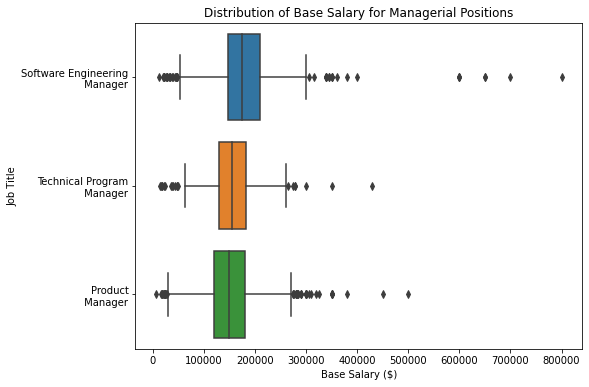

In [ ]:
boxplot_managers_salary = sns.boxplot(data = pd_managers_df, x = "basesalary", y = "title", 
                               order = ["Software Engineering Manager", "Technical Program Manager", "Product Manager"])

boxplot_managers_salary.set_title("Distribution of Base Salary for Managerial Positions")
boxplot_managers_salary.set_xlabel("Base Salary ($)")
boxplot_managers_salary.set_ylabel("Job Title")
boxplot_managers_salary.set_yticklabels(["Software Engineering\n Manager", "Technical Program\n Manager", "Product\n Manager"])

[Text(0, 0, 'Software Engineering\n Manager'),
 Text(0, 0, 'Technical Program\n Manager'),
 Text(0, 0, 'Product\n Manager')]

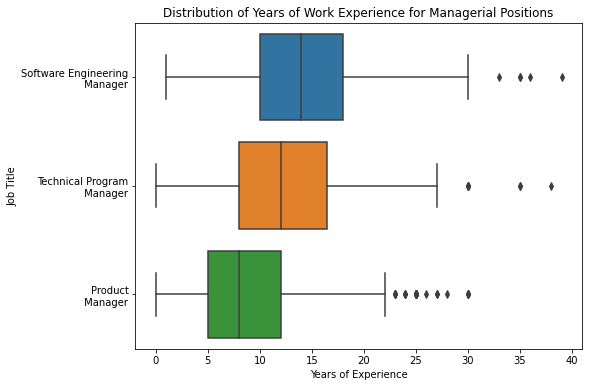

In [ ]:
boxplot_managers_exp = sns.boxplot(data = pd_managers_df, x = "yearsofexperience", y = "title", 
                               order = ["Software Engineering Manager", "Technical Program Manager", "Product Manager"])

boxplot_managers_exp.set_title("Distribution of Years of Work Experience for Managerial Positions")
boxplot_managers_exp.set_xlabel("Years of Experience")
boxplot_managers_exp.set_ylabel("Job Title")
boxplot_managers_exp.set_yticklabels(["Software Engineering\n Manager", "Technical Program\n Manager", "Product\n Manager"])

## What is the average base salary for each job title?

In [ ]:
#Create a pandas data frame with the number of observations per title
titles = salary_df_cleaned.groupBy("title").count().orderBy(desc("count")).toPandas()

Text(0, 0.5, 'Job Title')

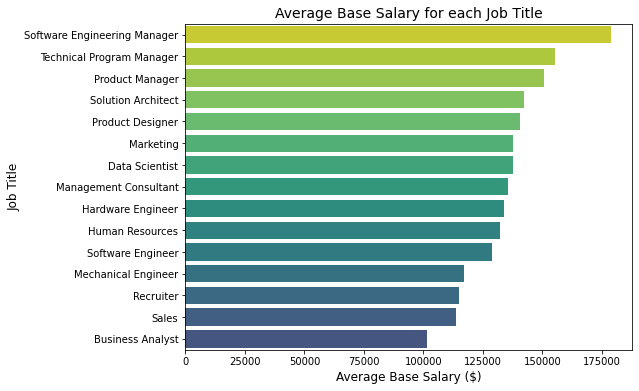

In [ ]:
title_comp = salary_df_cleaned.groupBy("title").agg(fn.mean("basesalary").alias(
    "avg_base_salary")).orderBy(desc("avg_base_salary"))

bar_avg_salary = sns.barplot(x = "avg_base_salary", y = "title", data = title_comp.toPandas(), 
                             palette = sns.color_palette("viridis_r", n_colors = len(titles) + 4))
bar_avg_salary.set_title("Average Base Salary for each Job Title", fontsize = 14)
bar_avg_salary.set_xlabel("Average Base Salary ($)", fontsize = 12)
bar_avg_salary.set_ylabel("Job Title", fontsize = 12)

## What is the average years of experience for each job title?

Text(0, 0.5, 'Job Title')

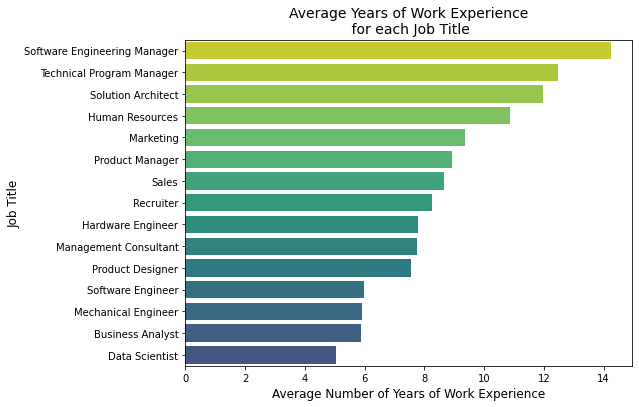

In [ ]:
title_years = salary_df_cleaned.groupBy("title").agg(fn.mean('yearsofexperience').alias(
    "avg_YOE")).orderBy(desc("avg_YOE"))

bar_avg_years = sns.barplot(x = "avg_YOE", y = "title",data = title_years.toPandas(), 
                            palette = sns.color_palette("viridis_r", n_colors = len(titles) + 4))
bar_avg_years.set_title("Average Years of Work Experience\n for each Job Title", fontsize = 14)
bar_avg_years.set_xlabel("Average Number of Years of Work Experience", fontsize = 12)
bar_avg_years.set_ylabel("Job Title", fontsize = 12)

## Checking Gender Distribution

Gender Counts for All Earners:
+------+-----+
|gender|count|
+------+-----+
| Other|  106|
|Female| 3879|
|  Male|17596|
+------+-----+



Text(0, 0.5, '')

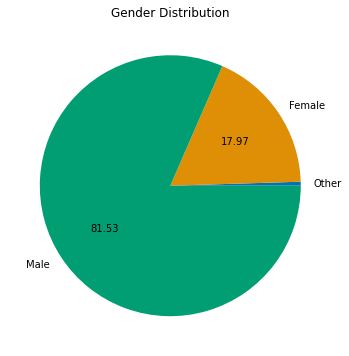

In [ ]:
#Create a plot of gender distribution
gender_dist = salary_df_cleaned.groupBy('gender').count().orderBy('count')
print("Gender Counts for All Earners:")
gender_dist.show()

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 5 else ''

# to add labels
def get_new_labels(sizes, labels):
  new_labels = [label for size, label in zip(sizes, labels)]
  return new_labels

sizes = gender_dist.toPandas()['count']
labels = gender_dist.toPandas()['gender']
colors = sns.color_palette("colorblind")
ax = gender_dist.toPandas().plot.pie(y = "count",
                      autopct=my_autopct, labels=get_new_labels(sizes, labels),
                      colors = colors)
ax.get_legend().remove()
plt.title("Gender Distribution")
ax.set_ylabel('')

## Compensation by Gender

Text(0, 0.5, 'Gender')

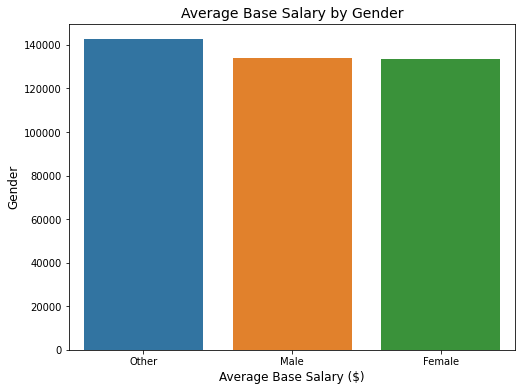

In [ ]:
#Create a bar plot of gender distribution
gender_compensation = salary_df_cleaned.groupBy("gender").agg(fn.avg('basesalary').alias(
    "avg_salary")).orderBy(desc("avg_salary"))

bar_gender_pay = sns.barplot(x = "gender", y = "avg_salary", data = gender_compensation.toPandas())
bar_gender_pay.set_title("Average Base Salary by Gender", fontsize = 14)
bar_gender_pay.set_xlabel("Average Base Salary ($)", fontsize = 12)
bar_gender_pay.set_ylabel("Gender", fontsize = 12)

## Highest Salaries for Men, Women, and Other

In [ ]:
#Salaries per gender
windowGender = Window.partitionBy("gender").orderBy(fn.col("basesalary").desc())
top_compensation_salary = salary_df_cleaned.withColumn("row", row_number().over(windowGender))
top_compensation_salary = top_compensation_salary.filter(fn.col("row") <= 10)

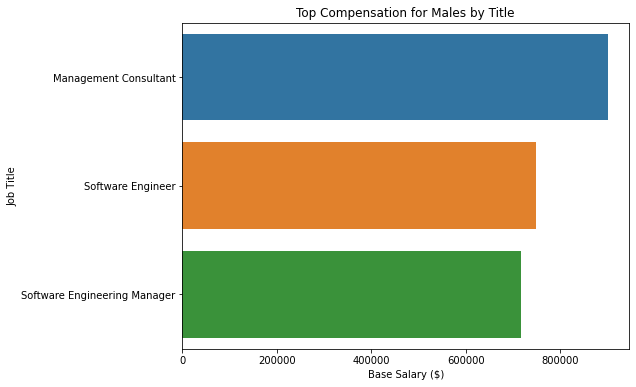

In [ ]:
top_compensation_salary_male = top_compensation_salary.filter(fn.col("gender") == "Male")
sns.barplot(x = "basesalary", y = 'title',
            data = top_compensation_salary_male.toPandas(), ci = None)
plt.title("Top Compensation for Males by Title")
plt.xlabel("Base Salary ($)")
plt.ylabel("Job Title")
plt.show()

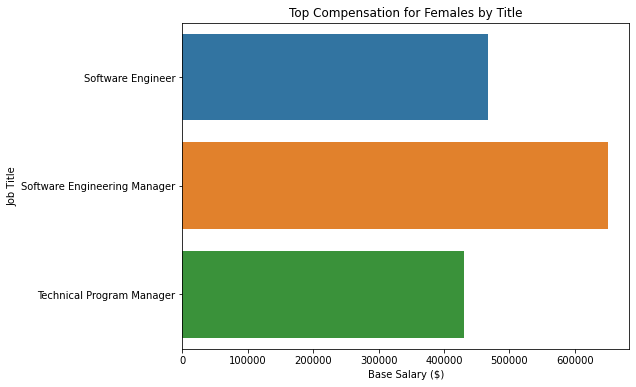

In [ ]:
top_compensation_salary_female = top_compensation_salary.filter(fn.col("gender") == "Female")
sns.barplot(x = "basesalary", y = 'title',
            data = top_compensation_salary_female.toPandas(), ci = None)
plt.title("Top Compensation for Females by Title")
plt.xlabel("Base Salary ($)")
plt.ylabel("Job Title")
plt.show()

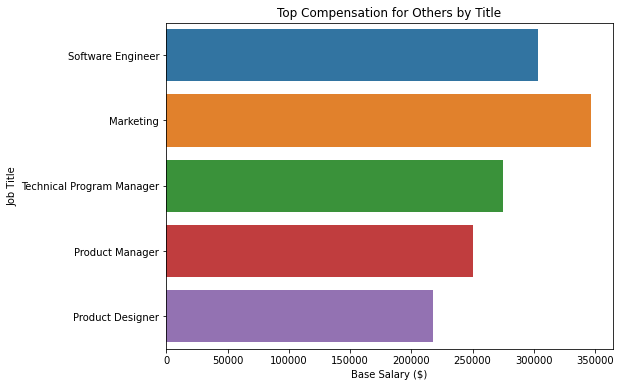

In [ ]:
top_compensation_salary_other = top_compensation_salary.filter(fn.col("gender") == "Other")
sns.barplot(x = "basesalary", y = 'title',
            data = top_compensation_salary_other.toPandas(), ci = None)
plt.title("Top Compensation for Others by Title")
plt.xlabel("Base Salary ($)")
plt.ylabel("Job Title")
plt.show()

## Checking Compensation by Race

Text(0, 0.5, '')

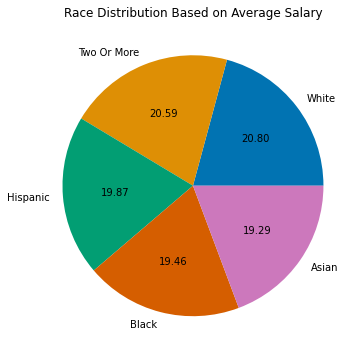

In [ ]:
#Create a plot of salaries by race
race_compensation = salary_df_cleaned.groupBy("Race").agg(fn.avg("basesalary").alias(
    "avg_salary")).orderBy(desc("avg_salary"))

sizes = race_compensation.toPandas()["avg_salary"]
labels = race_compensation.toPandas()["Race"]
colors = sns.color_palette("colorblind")
ax = race_compensation.toPandas().plot.pie(y = "avg_salary",
                      autopct = my_autopct, labels = get_new_labels(sizes, labels),
                      colors = colors)
ax.get_legend().remove()
plt.title("Race Distribution Based on Average Salary")
ax.set_ylabel('')

In [ ]:
#Count the number of observations per Race type
salary_df_cleaned.groupBy('Race').count().orderBy('count').show()

+-----------+-----+
|       Race|count|
+-----------+-----+
|      Black|  662|
|Two Or More|  766|
|   Hispanic| 1067|
|      White| 7675|
|      Asian|11411|
+-----------+-----+



## Violin Plots

Base Salary by Education for All Earners

Text(0, 0.5, 'Level of Education')

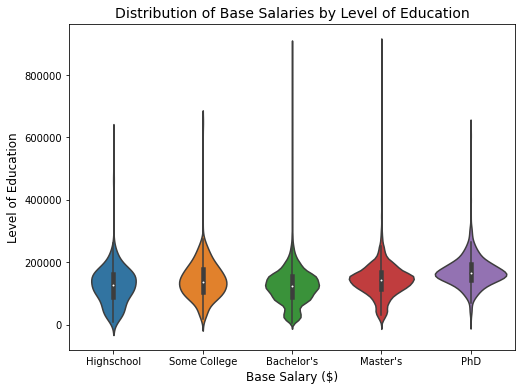

In [ ]:
violin_base_salary = sns.violinplot(data = salary_df_cleaned.toPandas(), x = "Education", 
                               y = "basesalary", order = ["Highschool", "Some College", "Bachelor's", "Master's", "PhD"])

violin_base_salary.set_title("Distribution of Base Salaries by Level of Education", fontsize = 14)
violin_base_salary.set_xlabel("Base Salary ($)", fontsize = 12)
violin_base_salary.set_ylabel("Level of Education", fontsize = 12)
# sns.move_legend(violin_gender, loc = "upper left", bbox_to_anchor = (1, 1))

Base Salary below 500k Grouped by Level of Education 

In [ ]:
#Filter data with a base salary less than 500,000
pd_below_500k_df = salary_df_cleaned.filter(salary_df_cleaned.basesalary <= 500000).toPandas()

Text(0.5, 0, 'Level of Education')

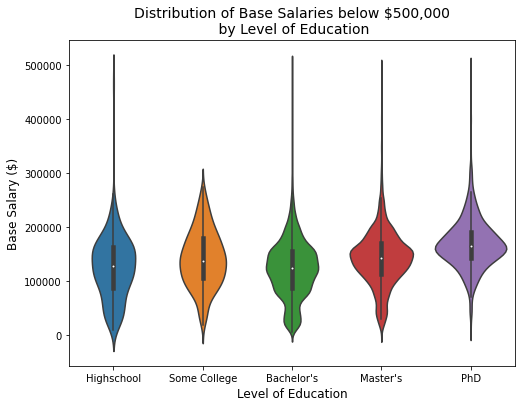

In [ ]:
# ordered by level of education
violin_below_500k = sns.violinplot(data = pd_below_500k_df, x = "Education", 
                               y = "basesalary", order = ["Highschool", "Some College", "Bachelor's", "Master's", "PhD"])

violin_below_500k.set_title("Distribution of Base Salaries below $500,000\n by Level of Education", fontsize = 14)
violin_below_500k.set_ylabel("Base Salary ($)", fontsize = 12)
violin_below_500k.set_xlabel("Level of Education", fontsize = 12)

# Maps

## World Map

In [ ]:
#Creating a subset of average base salary per country
avg_salary_map = salary_df_cleaned.select('country','basesalary').\
                                groupBy(fn.col('country')).\
                                agg(fn.avg('basesalary').alias('avg_salary'),fn.count('country').alias('Num_Obs')).\
                                filter('Num_Obs>2').orderBy(fn.desc('avg_salary')).toPandas()

In [ ]:
# read the geopandas dataset with latitude and longitude
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# join each average salary for each country
table = world.merge(avg_salary_map, how="left", left_on=['name'], right_on=['country'])

# drop na values
table = table.dropna(subset=['avg_salary'])

In [ ]:
# set the title
loc = 'Average Base Salary by Country'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   


# create a map
map_country = folium.Map()

# add the title
map_country.get_root().html.add_child(folium.Element(title_html))

# add the data
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['country', 'avg_salary'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Base Salary',
    nan_fill_color='#F5F5F5'
).add_to(map_country)

# uncomment the following line to show the world map
map_country

## US Map

In [ ]:
# calculate average salary by US state and number of observations
avg_salary_US = salary_df_cleaned.filter('country=="United States of America"').\
                               select('state','basesalary').\
                               groupBy(fn.col('state')).\
                               agg(fn.avg('basesalary').alias('avg_salary'),fn.count('state').alias('Num_Obs')).\
                               filter('Num_Obs>2').orderBy(fn.desc('avg_salary')).toPandas()

# save the url with the latitude and longitude of each US state
state_geo = f"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"

In [ ]:
fig = px.choropleth(avg_salary_US,
                    locations = 'state', 
                    locationmode = "USA-states", 
                    scope = "usa",
                    color = 'avg_salary',
                    color_continuous_scale = ["#FFFFFF","#F1FD87","#539B58"],
                    width = 1000, height = 600,
                    title = 'Total Dataset Average Base Salary by State of the U.S.',
                    labels = {'avg_salary': 'Thousands of Dollars'}
                    )

#Add labels of each state
fig.add_scattergeo(
    locations = avg_salary_US['state'],
    locationmode = "USA-states", 
    text = avg_salary_US['state'],
    mode = 'text', textfont = dict(size=10,color='black')
)

fig.update_layout(
      title_font_size = 22,
      title_x=0.45, 
         )

# uncomment the following line to show the US map
# fig.show()

# Machine Learning

In [ ]:
'''
The code below will drop companies that are not represented more than
20 times in our dataset.
Additionally, we will calculate a binary variable called salary_threshold
that will be used in the classification models below.
The current threshold is set to $125,000
'''

# The code below will drop companies that are not represented more than
# 20 times in our dataset 
salary_df_cleaned.createOrReplaceTempView('table')

salary_df_cleaned_reduced = spark.sql('''
with temp_table as (
    select company, count(company) as count
    from table
    group by company
    order by count(company) desc
)
select case when basesalary < 125000 then 0
else 1 end salary_threshold,
t1.* from table t1
left join temp_table t2 on
t2.company = t1.company
where t2.count > 20
''')

In [ ]:
# check how many outliers larger than 500,000
salary_df_cleaned_reduced.filter('basesalary>=500000').count()

34

In [ ]:
# show the companies with salaries larger than 300,000
salary_df_cleaned_reduced.filter('basesalary>=300000').select('company').groupBy('company').count().orderBy('company').show(30,truncate=False)

+---------------------+-----+
|company              |count|
+---------------------+-----+
|Amazon               |1    |
|Apple                |1    |
|Bloomberg            |5    |
|ByteDance            |2    |
|Capgemini            |1    |
|Cruise               |1    |
|Dell Technologies    |1    |
|Deloitte             |3    |
|Dropbox              |1    |
|Ernst & Young        |1    |
|Facebook             |2    |
|Goldman Sachs        |1    |
|Google               |10   |
|IBM                  |2    |
|Intel                |4    |
|LinkedIn             |2    |
|Microsoft Corporation|2    |
|Netflix              |72   |
|Oracle               |4    |
|PwC                  |1    |
|Salesforce           |7    |
|Snap                 |1    |
|VMware               |3    |
|Visa                 |1    |
|Walmart Labs         |1    |
|Yahoo                |1    |
+---------------------+-----+



In [ ]:
#Stratify data
salary_df_cleaned_reduced = salary_df_cleaned_reduced.withColumn('strat', fn.when(fn.col("basesalary")<=125000,fn.lit(0)).\
                                                        otherwise(fn.lit(1)))
# split the data set 
train, validation, test = salary_df_cleaned_reduced.randomSplit([0.5, 0.3, 0.2], seed=1)

## Linear Regression

In [ ]:
# create a pipeline of transformations
fe_pipe = Pipeline(stages=[feature.StringIndexer(inputCol='gender',handleInvalid='skip',outputCol='gender_indx'),
                           feature.StringIndexer(inputCol='Education',handleInvalid='skip',outputCol='Education_indx'),
                           feature.StringIndexer(inputCol='Race',handleInvalid='skip',outputCol='Race_indx'),
                           feature.StringIndexer(inputCol='company',handleInvalid='skip',outputCol='company_indx'),
                           feature.StringIndexer(inputCol='title',handleInvalid='skip',outputCol='title_indx'),
                           feature.StringIndexer(inputCol='country',handleInvalid='skip',outputCol='country_indx'),
                           feature.OneHotEncoder(inputCol='gender_indx', outputCol='dummy_gender'),
                           feature.OneHotEncoder(inputCol='company_indx', outputCol='dummy_company'),
                           feature.OneHotEncoder(inputCol='title_indx', outputCol='dummy_title'),
                           feature.OneHotEncoder(inputCol='Race_indx', outputCol='dummy_Race'),
                           feature.OneHotEncoder(inputCol='Education_indx', outputCol='dummy_Education'),
                           feature.OneHotEncoder(inputCol='country_indx', outputCol='dummy_country')])

lr_pipe = Pipeline(stages=[fe_pipe,
                           feature.VectorAssembler(inputCols=['yearsofexperience','yearsatcompany', 'dummy_gender','dummy_Education', 
                                                              'dummy_Race', 'dummy_company', 'dummy_title', 'dummy_country'], outputCol='features'),
                           regression.LinearRegression(labelCol='basesalary', featuresCol='features')])

In [ ]:
# fit the pipeline in training data
model = lr_pipe.fit(train)

In [ ]:
# apply the model to the teting data
eval = RegressionEvaluator(labelCol="basesalary", predictionCol="prediction", metricName="mse")

# show the Squared Errors
print("MSE built-in evaluator for TRAIN SET = %s" % eval.evaluate(model.transform(train)))
print("MSE built-in evaluator for VALIDATION SET = %s" % eval.evaluate(model.transform(validation)))
print("MSE built-in evaluator for TEST SET = %s" % eval.evaluate(model.transform(test)))

MSE built-in evaluator for TRAIN SET = 731182660.0563065
MSE built-in evaluator for VALIDATION SET = 841455762.4727373
MSE built-in evaluator for TEST SET = 742129538.1347305


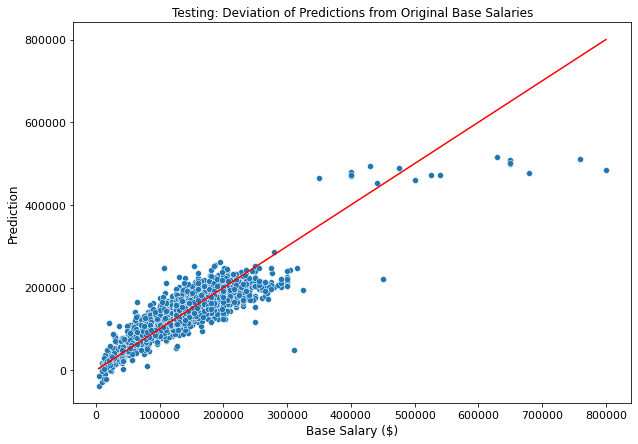

In [ ]:
# plot to see how the model is predicting
results = model.transform(test).toPandas()
fig, ax = plt.subplots(figsize=(10, 7))
p1 = sns.scatterplot(data=results, x='basesalary', y='prediction')
p2 = sns.lineplot(data=results, x='basesalary', y='basesalary', color='r', ax=ax)
plt.title('Testing: Deviation of Predictions from Original Base Salaries')
ax.set_ylabel('Prediction', fontsize = 12) # Y label
ax.set_xlabel('Base Salary ($)', fontsize = 12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)

### Linear Regression Inference

In [ ]:
# show intercept
model.stages[-1].intercept

36313.28656838051

In [ ]:
# categories in the intercept
[model.stages[0].stages[0].labels[-1],
 model.stages[0].stages[1].labels[-1],
 model.stages[0].stages[2].labels[-1],
 model.stages[0].stages[3].labels[-1],
 model.stages[0].stages[4].labels[-1],
 model.stages[0].stages[5].labels[-1]]

['Other',
 'Highschool',
 'Black',
 'ThoughtWorks',
 'Human Resources',
 'United Arab Emirates']

In [ ]:
# all the labels
first_coeff = [(x,'First') for x in model.stages[1].getInputCols()[:2]]
gender_coeff=[(x,'Gender') for x in model.stages[0].stages[0].labels[:-1]]
education_coeff=[(x,'Education') for x in model.stages[0].stages[1].labels[:-1]]
race_coeff=[(x,'Race') for x in model.stages[0].stages[2].labels[:-1]]
company_coeff=[(x,'Company') for x in model.stages[0].stages[3].labels[:-1]]
title_coeff=[(x,'Title') for x in model.stages[0].stages[4].labels[:-1]]
country_coeff=[(x,'Country') for x in model.stages[0].stages[5].labels[:-1]]

labels=first_coeff + gender_coeff + education_coeff + race_coeff + company_coeff + title_coeff + country_coeff
inf_pd=pd.DataFrame({'tuple':labels,
                     'Value':model.stages[-1].coefficients})
inf_pd[['predictor', 'predictor_group']] = pd.DataFrame(inf_pd['tuple'].tolist(), index=inf_pd.index)
inf_pd.drop(columns=['tuple'], inplace=True)
inf_pd = inf_pd[['predictor', 'predictor_group','Value']]
inf_pd.head()

,predictor,predictor_group,Value
0,yearsofexperience,First,3695.112490
1,yearsatcompany,First,291.238186
2,Male,Gender,7770.718079
3,Female,Gender,3290.059816
4,Bachelor's,Education,1616.792360


In [ ]:
# coefficients for years
inf_pd.loc[inf_pd['predictor_group']=='First'].sort_values('Value', ascending=False)

,predictor,predictor_group,Value
0,yearsofexperience,First,3695.112490
1,yearsatcompany,First,291.238186


In [ ]:
# coefficients for gender
inf_pd.loc[inf_pd['predictor_group']=='Gender'].sort_values('Value', ascending=False)

,predictor,predictor_group,Value
2,Male,Gender,7770.718079
3,Female,Gender,3290.059816


In [ ]:
# coefficients for country
table_country = inf_pd.loc[inf_pd['predictor_group']=='Country'].sort_values('Value', ascending=False)
print(table_country.head(5))
print(table_country.tail(5))

                    predictor predictor_group         Value
200              South Africa         Country  68327.259662
216              Saudi Arabia         Country  60181.347402
182               Switzerland         Country  46685.159471
199                   Denmark         Country  45168.175074
170  United States of America         Country  29620.970872
    predictor predictor_group          Value
198  Colombia         Country  -75761.773270
206   Armenia         Country  -78098.240023
197   Romania         Country  -79371.049482
202     Chile         Country  -89770.919733
209     Egypt         Country -109542.538307


In [ ]:
# coefficients for company
table_company = inf_pd.loc[inf_pd['predictor_group']=='Company'].sort_values('Value', ascending=False)
print(table_company.head(6))
print(table_company.tail(5))

     predictor predictor_group          Value
46     Netflix         Company  324862.079287
112     Cruise         Company   52645.072907
84         Box         Company   52584.651001
131      Waymo         Company   52508.119847
61      Stripe         Company   49709.385863
105  Robinhood         Company   49052.677485
                     predictor predictor_group         Value
88   Tata Consultancy Services         Company -36869.657024
128                 Supermicro         Company -43629.194384
111                  Cognizant         Company -43882.874730
109                     Cerner         Company -47743.654268
113                    Infosys         Company -52981.747143


In [ ]:
# coefficients for title
table_title = inf_pd.loc[inf_pd['predictor_group']=='Title'].sort_values('Value', ascending=False)
print(table_title.head(5))
print(table_title.tail(5))

                        predictor predictor_group         Value
158  Software Engineering Manager           Title  45320.552949
163         Management Consultant           Title  39562.875622
157               Product Manager           Title  32834.163189
160                Data Scientist           Title  28143.849392
156             Software Engineer           Title  27870.768513
               predictor predictor_group         Value
166            Marketing           Title  13463.906086
168  Mechanical Engineer           Title  12447.668117
167                Sales           Title   4678.272149
165     Business Analyst           Title   4044.255385
169            Recruiter           Title -18529.703410


In [ ]:
# coefficients for education
table_education = inf_pd.loc[inf_pd['predictor_group']=='Education'].sort_values('Value', ascending=False)
table_education

,predictor,predictor_group,Value
6,PhD,Education,24720.911531
5,Master's,Education,6293.554238
4,Bachelor's,Education,1616.792360
7,Some College,Education,-6670.300490


In [ ]:
# coefficients for race
table_race = inf_pd.loc[inf_pd['predictor_group']=='Race'].sort_values('Value', ascending=False)
table_race

,predictor,predictor_group,Value
8,Asian,Race,9422.788194
11,Two Or More,Race,8836.374215
9,White,Race,7606.622452
10,Hispanic,Race,1110.750611


## Logistic Regression

In [ ]:
# create a pipeline of transformations
fe_pipe_logR = Pipeline(stages=[feature.StringIndexer(inputCol='gender',handleInvalid='skip',outputCol='gender_indx'),
                           feature.StringIndexer(inputCol='company',handleInvalid='skip',outputCol='company_indx'),
                           feature.StringIndexer(inputCol='title',handleInvalid='skip',outputCol='title_indx'),
                           feature.StringIndexer(inputCol='Race',handleInvalid='skip',outputCol='Race_indx'),
                           feature.StringIndexer(inputCol='Education',handleInvalid='skip',outputCol='Education_indx'),
                           feature.StringIndexer(inputCol='country',handleInvalid='skip',outputCol='country_indx'),
                           feature.OneHotEncoder(inputCol='gender_indx', outputCol='dummy_gender'),
                           feature.OneHotEncoder(inputCol='company_indx', outputCol='dummy_company'),
                           feature.OneHotEncoder(inputCol='title_indx', outputCol='dummy_title'),
                           feature.OneHotEncoder(inputCol='Race_indx', outputCol='dummy_Race'),
                           feature.OneHotEncoder(inputCol='Education_indx', outputCol='dummy_Education'),
                           feature.OneHotEncoder(inputCol='country_indx', outputCol='dummy_country')])

va = feature.VectorAssembler(inputCols=['yearsofexperience', 'dummy_company', 'dummy_title', 'dummy_country',
                                                              'yearsatcompany','dummy_Race','dummy_Education','dummy_gender'], outputCol='features')

#Declare the logistic regression
logR = classification.LogisticRegression(labelCol='strat', featuresCol='features')

#Fit a model with default hyperparameters
logR_pipe = Pipeline(stages=[fe_pipe_logR, va,logR]).fit(train)

In [ ]:
#Cell to tune the model
if enable_grid:
    # set the pipeline model
    logR_pipe_1 = Pipeline(stages=[fe_pipe_logR, va, logR])
    
    # select the parameters to tune
    grid = ParamGridBuilder().\
    addGrid(logR.regParam, [0., 0.01, 0.02, 0.03]).\
    addGrid(logR.elasticNetParam, [0., 0.1, 0.2, 0.4]).\
    build()
    
    # set the evaluator used in the cross validation
    evaluator = BinaryClassificationEvaluator(labelCol='strat', 
                                          rawPredictionCol="rawPrediction", 
                                          metricName = 'areaUnderROC')
    
    # create a cross validation with the tuning parameters
    crossval = CrossValidator(estimator=logR_pipe_1,  
                          evaluator=evaluator,
                          estimatorParamMaps=grid, 
                          numFolds=5,
                          seed=718)
    
    # train the model with the cross-validation features
    model_fitted = crossval.fit(train)

    # show the ROC score for training
    print("Average training ROC score: ", model_fitted.avgMetrics)

    # show the ROC score for validation
    print("TRAIN ROC score: ",evaluator.evaluate(model_fitted.bestModel.transform(train)))
    print("Validation ROC score: ",evaluator.evaluate(model_fitted.bestModel.transform(validation)))

    # print the best parameters
    print("Best ElasticNet:", model_fitted.bestModel.stages[-1]._java_obj.getElasticNetParam())
    print("Best regularization:", model_fitted.bestModel.stages[-1]._java_obj.getRegParam())

In [ ]:
#Declare the evaluator
evaluator = BinaryClassificationEvaluator(labelCol = 'strat', 
                                          rawPredictionCol = "rawPrediction", 
                                          metricName = 'areaUnderROC')

In [ ]:
# hard-coded values from best logistic regression model
alpha_best=0.2
lambda_best=0.01
logR = classification.LogisticRegression(labelCol='strat', featuresCol='features')

logR_pipe = Pipeline(stages=[fe_pipe_logR, va,logR]).fit(train)

#Print statistics of the model
print("TRAIN ROC score: ",evaluator.evaluate(logR_pipe.transform(train)))
print("VALIDATION ROC score: ",evaluator.evaluate(logR_pipe.transform(validation)))
print("TEST ROC score: ",evaluator.evaluate(logR_pipe.transform(test)))

TRAIN ROC score:  0.9462395435489462
VALIDATION ROC score:  0.923030951182689
TEST ROC score:  0.933573760990642


## PCA and K-Means

In [ ]:
#Filter the data for PCA 
salary_cl2 = salary_df_cleaned.withColumn("text", fn.concat_ws(' ', fn.col('company'), fn.col('title'), fn.col('Race'))).\
                               filter('country=="United States of America"')

In [ ]:
# set the tokenizer
tokenizer = feature.RegexTokenizer(minTokenLength=2)\
  .setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

# getting the stopwords dictionary
stop_words = requests.get('https://raw.githubusercontent.com/wewilli1/ist718_data/master/stop_words.txt').text.split()

# set stopword remover
sw_filter = feature.StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

# set tf scores
cv = feature.CountVectorizer(inputCol='filtered', outputCol='tf')

# set tfidf scores
idf = feature.IDF(inputCol='tf', outputCol='features')

In [ ]:
#Create a pipeline for feature engineering
pipe_features = Pipeline(stages=[tokenizer, sw_filter, cv, idf])

In [ ]:
# show the maximum number of components
pipe_pca = pipe_features.fit(salary_cl2)
pipe_pca.stages[-1].idf.size

1010

In [ ]:
# set standardizer
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

# set PCA with the maximum number of components
pca = feature.PCA(k=pipe_pca.stages[-1].idf.size, inputCol='centered_features', outputCol='scores')

# create pipeline with the specifications and fit it
pipe_pca1= Pipeline(stages=[pipe_features,center, pca]).fit(salary_cl2)

Text(0, 0.5, 'Proportion Variance Explained')

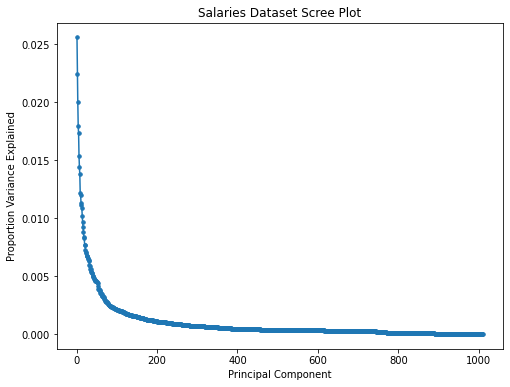

In [ ]:
# generate Scree plot with explained variance 
# set the size of the plot
plt.figure(figsize=(8, 6))

# get the explained variance
explained_var = pipe_pca1.stages[-1].explainedVariance

# create the plot
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker="o", markersize=3.5)
plt.title("Salaries Dataset Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

In [ ]:
# set standardizer
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')
# set normalizer
norm = feature.Normalizer(inputCol="centered_features", outputCol="norm_tfidf", p=2.0)
# set Kmeans model
kmeans = clustering.KMeans(k=4, featuresCol='scores', predictionCol='kmeans_feat', initMode='random', seed=28)
# set PCA to calculate two principal components
pca = feature.PCA(k=2, inputCol='norm_tfidf', outputCol='scores')

# generate pipeline with specifications and fit it
pipe_pca2= Pipeline(stages=[pipe_features, center, norm, pca, kmeans]).fit(salary_cl2)

In [ ]:
# creating an expression to filter the labels of interesting points
programs = fn.col('labels').isin(['Amazon Software Engineer White', 'Amazon Software Engineer Asian',
                                  'Microsoft Corporation Software Engineer White',
                                  'Microsoft Corporation Software Engineer Asian','Google Software Engineer White'])

# create a column with the labels
labels = np.array(salary_cl2.withColumn("labels",fn.concat_ws(' ', fn.col('company'), fn.col('title'), fn.col('Race'))).\
                                      withColumn("Select_label",fn.when(programs, fn.col('labels')).otherwise("")).\
                                      select('Select_label').rdd.map(lambda x: x['Select_label']).collect())

# get the assigned group for each record
cluster=np.array(pipe_pca2.transform(salary_cl2).select('kmeans_feat').rdd.map(lambda x: x['kmeans_feat']).collect())

# get the PCA scores to plot them
X = np.array(pipe_pca2.transform(salary_cl2).select('scores').rdd.map(lambda x: x['scores']).collect())

In [ ]:
#Create a data frame with the labels
labels_df = np.array(salary_cl2.withColumn("labels",fn.concat_ws(' ', fn.col('company'), fn.col('title'), fn.col('Race'))).\
                                      withColumn("Select_label",fn.col('labels')).\
                                      select('Select_label').rdd.map(lambda x: x['Select_label']).collect())

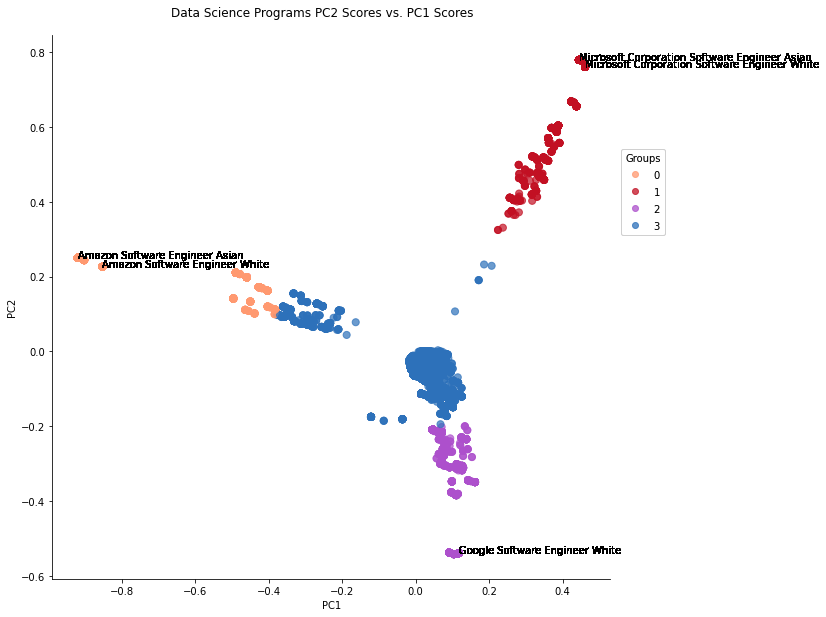

In [ ]:
# import a map to plot by cluster number
from matplotlib.colors import ListedColormap

# create a plot of the clusters
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

# select the colors for each cluster
colors = ListedColormap(["#FF9970", "#C21023", "#AD50CC", "#2D71BA"])

# create the scatter plot
scatter=ax.scatter(X[:,0], X[:,1], c=cluster, cmap=colors, alpha=0.7, s=50)
fig.suptitle("Data Science Programs PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adding legends for the clusters
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Groups",
                    bbox_to_anchor=(1.01, 0.8))
ax.add_artist(legend1)

# adding the labels of interesting points
for i, txt in enumerate(labels):
    ax.annotate(txt, (X[i,0], X[i,1]))

# display(plt.show())

## Random Forest (Regression)

In [ ]:
#Create an index of each categorical variable
companyStringIndex = StringIndexer(inputCol='company', outputCol='companyIndex')
titleStringIndex = StringIndexer(inputCol='title', outputCol='titleIndex')
countryStringIndex = StringIndexer(inputCol='country', outputCol='countryIndex', handleInvalid='keep')
genderStringIndex = StringIndexer(inputCol='gender', outputCol='genderIndex')
raceStringIndex = StringIndexer(inputCol='Race', outputCol='raceIndex')
educationStringIndex = StringIndexer(inputCol='Education', outputCol='educationIndex')

In [ ]:
#Create the vector assembler
va = VectorAssembler(inputCols=[
    'companyIndex','titleIndex', 'countryIndex','genderIndex', 'raceIndex',
    'educationIndex', 'yearsofexperience',
    'yearsatcompany'],
    outputCol='features')

In [ ]:
#Create a pipeline to index the categorical variables
string_va_pipeline = Pipeline(stages=[
    companyStringIndex, titleStringIndex, countryStringIndex, genderStringIndex, raceStringIndex,
    educationStringIndex,
    va
])

### Base RF Model

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# The max bins parameter needs to be changed in order for the code below to work
# since there are more than 32 different values in the company column
max_bins = train.select('company').distinct().count() + 1

base_rf = RandomForestRegressor(featuresCol='features', labelCol='basesalary',
                                maxBins=max_bins)
base_rf_pipe = Pipeline(stages=[string_va_pipeline, base_rf]).fit(train)

Base RF MSE

In [ ]:
#Score the model
base_rf_mse = base_rf_pipe.transform(validation).select(['basesalary','prediction']).withColumn('mse', (fn.col('basesalary') - fn.col('prediction'))**2).agg({'mse':'mean'}).collect()[0][0]
base_rf_mse

1059978124.6109802

### Grid Search RF Model

In [ ]:
if enable_grid:
    # Mse to be used in grid search
    mse = fn.mean((fn.col('basesalary') - fn.col('prediction'))**2).alias('mse')

    # Pipeline creation
    grid_search_rf = RandomForestRegressor(featuresCol='features', labelCol='basesalary',
                                maxBins = max_bins)
    grid_search_rf_pipeline = Pipeline(stages = [string_va_pipeline, grid_search_rf])

    # building the grid
    grid = ParamGridBuilder().\
    addGrid(grid_search_rf_pipeline.getStages()[-1].maxDepth, [5,10,15, 20]).\
    addGrid(grid_search_rf_pipeline.getStages()[-1].numTrees, [10,15,20,25,30,35]).\
    addGrid(grid_search_rf_pipeline.getStages()[-1].minInstancesPerNode, [5,10,15,20,25]).\
    build()
    # fit the models
    all_models = []
    for j in range(len(grid)):
        model = grid_search_rf_pipeline.fit(train, grid[j])
        all_models.append(model)
        print(f'Model {j+1}/{len(grid)} completed...')
    # find the mse for each model created above
    mse = [m.transform(test).select(mse).collect()[0][0] for m in all_models]
    # find the best model index 
    best_model_idx = np.argmin(mse)

    print(f'Lowest MSE:                         {mse[np.argmin(mse)]}')
    print(f'Best maxDepth parameter:            {list(grid[best_model_idx].values())[0]}')
    print(f'Best numTrees parameter:            {list(grid[best_model_idx].values())[1]}')
    print(f'Best minInstancesPerNode parameter: {list(grid[best_model_idx].values())[2]}')

In [ ]:
# hard-coded values from best RF model
best_max_depth_gs_rf = 15
best_num_trees_gs_rf = 15
best_min_inst_gs_rf = 20

# initialize RandomForestRegressor
gs_rf_best = RandomForestRegressor(featuresCol='features', labelCol='basesalary',
                                   maxDepth=best_max_depth_gs_rf,
                                   numTrees=best_num_trees_gs_rf,
                                   minInstancesPerNode=best_min_inst_gs_rf,
                                   maxBins=max_bins)

# create pipeline and fit it
gs_rf_pipe = Pipeline(stages=[string_va_pipeline, gs_rf_best]).fit(train)

Grid Search RF MSE

In [ ]:
#Score the model
gs_rf_mse = gs_rf_pipe.transform(validation).select(['basesalary','prediction']).withColumn('mse', (fn.col('basesalary') - fn.col('prediction'))**2).agg({'mse':'mean'}).collect()[0][0]
gs_rf_mse

889684150.0201848

## GBT (Regression)

### Base GBT Model

In [ ]:
#Create a GBT regressor model with default features
from pyspark.ml.regression import GBTRegressor

base_gbt = GBTRegressor(featuresCol='features', labelCol='basesalary',
                                maxBins=max_bins)
base_gbt_pipe = Pipeline(stages=[string_va_pipeline, base_gbt]).fit(train)

Base GBT MSE

In [ ]:
#Score the model
base_gbt_mse = base_gbt_pipe.transform(validation).select(['basesalary','prediction']).withColumn('mse', (fn.col('basesalary') - fn.col('prediction'))**2).agg({'mse':'mean'}).collect()[0][0]
base_gbt_mse

929294576.3824052

### Grid Search GBT Model

In [ ]:
if enable_grid:
    # Pipeline creation
    grid_search_gbt = GBTRegressor(featuresCol='features', labelCol='basesalary',
                                    maxBins=max_bins)
    grid_search_gbt_pipeline = Pipeline(stages=[string_va_pipeline, grid_search_gbt])

    # Mse to be used in grid search
    mse = fn.mean((fn.col('basesalary') - fn.col('prediction'))**2).alias('mse')

    # building the grid
    grid = ParamGridBuilder().\
    addGrid(grid_search_gbt_pipeline.getStages()[-1].maxDepth, [5,10,15,20]).\
    addGrid(grid_search_gbt_pipeline.getStages()[-1].maxIter, [5,10,15,20]).\
    addGrid(grid_search_gbt_pipeline.getStages()[-1].minInstancesPerNode, [5,10,15,20]).\
    addGrid(grid_search_gbt_pipeline.getStages()[-1].stepSize, [0.1,0.3,0.5]).\
    build()
    # fit the models
    all_models_gbt = []
    for j in range(len(grid)):
        model = grid_search_gbt_pipeline.fit(train, grid[j])
        all_models_gbt.append(model)
        print(f'Model {j+1}/{len(grid)} completed...')
    # find the mse for each model created above
    gbt_mse = [m.transform(test).select(mse).collect()[0][0] for m in all_models_gbt]
    # find the best model index 
    best_model_idx_gbt = np.argmin(gbt_mse)

    print(f'Lowest MSE:                         {gbt_mse[np.argmin(gbt_mse)]}')
    print(f'Best maxDepth parameter:            {list(grid[best_model_idx_gbt].values())[0]}')
    print(f'Best maxIter parameter:             {list(grid[best_model_idx_gbt].values())[1]}')
    print(f'Best minInstancesPerNode parameter: {list(grid[best_model_idx_gbt].values())[2]}')
    print(f'Best stepSize parameter:            {list(grid[best_model_idx_gbt].values())[3]}')

In [ ]:
# hard-coded values from best GBT model
best_max_depth_gs_gbt = 5
best_max_iter_gs_gbt = 20
best_min_inst_gs_gbt = 15
best_step_size_gs_gbt = 0.1

# initialize GBTRegressor
gs_gbt_best = GBTRegressor(featuresCol='features', labelCol='basesalary',
                           maxDepth=best_max_depth_gs_gbt,
                           maxIter=best_max_iter_gs_gbt,
                           minInstancesPerNode=best_min_inst_gs_gbt,
                           stepSize=best_step_size_gs_gbt,
                           maxBins=max_bins)

# create pipeline and fit it
gs_gbt_pipe = Pipeline(stages=[string_va_pipeline, gs_gbt_best]).fit(train)

Grid Search GBT MSE

In [ ]:
#Score the model
gs_gbt_mse = gs_gbt_pipe.transform(validation).select(['basesalary','prediction']).withColumn('mse', (fn.col('basesalary') - fn.col('prediction'))**2).agg({'mse':'mean'}).collect()[0][0]
gs_gbt_mse

887528654.9830371

## Compare MSE of RF and GBT Regression Models

In [ ]:
#Create a data frame with performance of each model
compare_mse_df = pd.DataFrame(list(zip(['RF Base', 'RF Grid Search','GBT Base','GBT Grid Search'],
                                        [base_rf_mse, gs_rf_mse, base_gbt_mse, gs_gbt_mse])),
                               columns = ['Model','Validation_MSE'])

compare_mse_df.sort_values(by='Validation_MSE').reset_index(drop=True)

,Model,Validation_MSE
0,GBT Grid Search,8.875287e+08
1,RF Grid Search,8.896842e+08
2,GBT Base,9.292946e+08
3,RF Base,1.059978e+09


Feature Importance of Grid Search GBT Regression Model

In [ ]:
#Extract feature importance
gbt_gs_feature_importance = pd.DataFrame(list(zip(['Company','Title', 'Country',
                                                    'Gender', 'Race',
                                                    'Education', 'Years_of_Experience',
                                                    'Years_at_Company'],
                                                   gs_gbt_pipe.stages[-1].featureImportances.toArray())),
                                          columns = ['feature','importance']).sort_values('importance',ascending=False).reset_index(drop=True)
gbt_gs_feature_importance

,feature,importance
0,Company,0.413633
1,Country,0.223229
2,Years_of_Experience,0.178901
3,Title,0.120970
4,Education,0.037965
5,Years_at_Company,0.016830
6,Race,0.007491
7,Gender,0.000980


### Difference between Actual and Predicted Salary for Grid Search GBT

In [ ]:
#Calculate the differences between prediction and observed data
df = gs_gbt_pipe.transform(validation).toPandas()
df['difference'] = (df['prediction'] - df['basesalary']).abs().round()

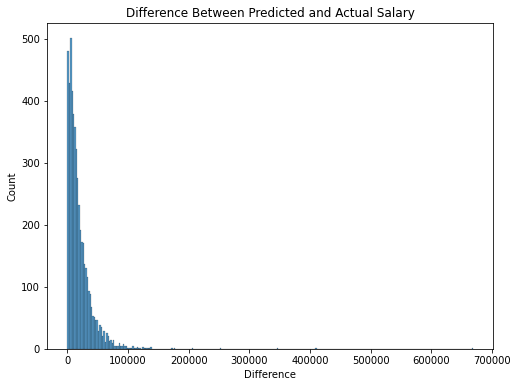

In [ ]:
#Create a plot of differences
sns.histplot(data=df, x='difference')
plt.title('Difference Between Predicted and Actual Salary')
plt.xlabel('Difference')
plt.show()

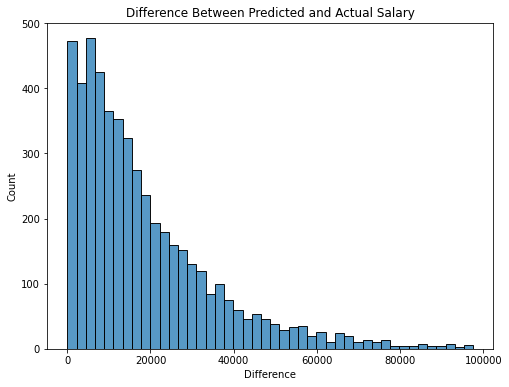

In [ ]:
#Create a plot with a subset of differences
sns.histplot(data=df[df['difference'] < 100000], x='difference')
plt.title('Difference Between Predicted and Actual Salary')
plt.xlabel('Difference')
plt.show()

## RF and GBT (Classification)

### Base RF Model

In [ ]:
#Create a Random forest with default hyperparameters
from pyspark.ml.classification import RandomForestClassifier

base_rf_c = RandomForestClassifier(featuresCol='features', labelCol='salary_threshold',
                                maxBins=max_bins)
base_rf_pipe_c = Pipeline(stages=[string_va_pipeline, base_rf_c]).fit(train)

Base Classification RF Accuracy

In [ ]:
#Score the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
bce = BinaryClassificationEvaluator(labelCol='salary_threshold')

base_rf_acc = bce.evaluate(base_rf_pipe_c.transform(validation))
base_rf_acc

0.8921928292893132

### Grid Search RF Model

In [ ]:
if enable_grid:
    # Pipeline creation
    grid_search_rf_class = RandomForestClassifier(featuresCol='features', labelCol='salary_threshold',
                                    maxBins=max_bins)
    grid_search_rfc_pipeline = Pipeline(stages=[string_va_pipeline, grid_search_rf_class])

    # Accuracy metric to use below
    bce = BinaryClassificationEvaluator(labelCol='salary_threshold')
    
    # building the grid
    grid = ParamGridBuilder().\
    addGrid(grid_search_rfc_pipeline.getStages()[-1].maxDepth, [5,10,15,20]).\
    addGrid(grid_search_rfc_pipeline.getStages()[-1].numTrees, [10,15,20,25,30,35]).\
    addGrid(grid_search_rfc_pipeline.getStages()[-1].minInstancesPerNode, [5,10,15,20,25]).\
    build()
    # fit the models
    all_models_rfc = []
    for j in range(len(grid)):
        model = grid_search_rfc_pipeline.fit(train, grid[j])
        all_models_rfc.append(model)
        print(f'Model {j+1}/{len(grid)} completed...')
    # find the accuracy for each model created above
    rfc_class = [bce.evaluate(m.transform(test)) for m in all_models_rfc]
    # find the best model index 
    best_model_idx_rfc = np.argmax(rfc_class)

    print(f'Best Accuarcy:                      {rfc_class[np.argmax(rfc_class)]}')
    print(f'Best maxDepth parameter:            {list(grid[best_model_idx_rfc].values())[0]}')
    print(f'Best numTrees parameter:            {list(grid[best_model_idx_rfc].values())[1]}')
    print(f'Best minInstancesPerNode parameter: {list(grid[best_model_idx_rfc].values())[2]}')

In [ ]:
#Train the best model
best_max_depth_gs_rf_c = 20
best_num_trees_gs_rf_c = 25
best_min_inst_gs_rf_c = 5

gs_rf_c = RandomForestClassifier(featuresCol='features', labelCol='salary_threshold',
                                   maxDepth=best_max_depth_gs_rf_c,
                                   numTrees=best_num_trees_gs_rf_c,
                                   minInstancesPerNode=best_min_inst_gs_rf_c,
                                   maxBins=max_bins)
gs_rf_pipe_c = Pipeline(stages=[string_va_pipeline, gs_rf_c]).fit(train)

Grid Search RF Accurcy

In [ ]:
#Score the model
gs_rf_acc = bce.evaluate(gs_rf_pipe_c.transform(validation))
gs_rf_acc

0.9289696061351368

### Base GBT Model

In [ ]:
#Create a GBT model with default features
from pyspark.ml.classification import GBTClassifier

base_gbt_c = GBTClassifier(featuresCol='features', labelCol='salary_threshold',
                                maxBins=max_bins)
base_gbt_pipe_c = Pipeline(stages=[string_va_pipeline, base_gbt_c]).fit(train)

Base GBT Accuracy

In [ ]:
#Score the model
base_gbt_acc = bce.evaluate(base_gbt_pipe_c.transform(validation))
base_gbt_acc

0.9266137974889769

### Grid Search GBT Model

In [ ]:
if enable_grid:
    # Pipeline creation
    grid_search_gbt_class = GBTClassifier(featuresCol='features', labelCol='salary_threshold',
                                    maxBins=max_bins)
    grid_search_gbt_pipeline = Pipeline(stages=[string_va_pipeline, grid_search_gbt_class])

    # Accuracy metric to use below
    bce = BinaryClassificationEvaluator(labelCol='salary_threshold')

    # building the grid
    grid = ParamGridBuilder().\
    addGrid(grid_search_gbt_pipeline.getStages()[-1].maxDepth, [5,10,15,20]).\
    addGrid(grid_search_gbt_pipeline.getStages()[-1].maxIter, [5,10,15,20]).\
    addGrid(grid_search_gbt_pipeline.getStages()[-1].minInstancesPerNode, [5,10,15,20]).\
    addGrid(grid_search_gbt_pipeline.getStages()[-1].stepSize, [0.1,0.3,0.5]).\
    build()
    # fit the models
    all_models_gbt = []
    for j in range(len(grid)):
        model = grid_search_gbt_pipeline.fit(train, grid[j])
        all_models_gbt.append(model)
        print(f'Model {j+1}/{len(grid)} completed...')
    # find the accuracy for each model created above
    gbt_class = [bce.evaluate(m.transform(test)) for m in all_models_gbt]
    # find the best model index 
    best_model_idx_gbt = np.argmax(gbt_class)

    print(f'Best Accuarcy:                      {gbt_class[np.argmax(gbt_class)]}')
    print(f'Best maxDepth parameter:            {list(grid[best_model_idx_gbt].values())[0]}')
    print(f'Best maxIter parameter:             {list(grid[best_model_idx_gbt].values())[1]}')
    print(f'Best minInstancesPerNode parameter: {list(grid[best_model_idx_gbt].values())[2]}')
    print(f'Best stepSize parameter:            {list(grid[best_model_idx_gbt].values())[3]}')

In [ ]:
#Create the best GBT model
best_max_depth_gs_gbt_c = 5
best_max_iter_gs_gbt_c = 20
best_min_inst_gs_gbt_c = 15
best_step_size_gs_gbt_c = 0.3

gs_gbt_c = GBTClassifier(featuresCol='features', labelCol='salary_threshold',
                         maxDepth=best_max_depth_gs_gbt_c,
                         maxIter=best_max_iter_gs_gbt_c,
                         minInstancesPerNode=best_min_inst_gs_gbt_c,
                         stepSize=best_step_size_gs_gbt_c,
                         maxBins=max_bins)
gs_gbt_pipe_c = Pipeline(stages=[string_va_pipeline, gs_gbt_c]).fit(train)

Grid Search GBT Accuracy

In [ ]:
#Score the model
gs_gbt_acc = bce.evaluate(gs_gbt_pipe_c.transform(validation))
gs_gbt_acc

0.9307784441168596

## Compare Accuracies of RF and GBT Classification Models

In [ ]:
#Create a data frame with the performance of each classification model
compare_acc_df = pd.DataFrame(list(zip(['RF Base', 'RF Grid Search','GBT Base','GBT Grid Search'],
                                        [base_rf_acc, gs_rf_acc, base_gbt_acc, gs_gbt_acc])),
                               columns = ['Model','Validation_Accuracy'])

compare_acc_df.sort_values(by='Validation_Accuracy', ascending=False).reset_index(drop=True)

,Model,Validation_Accuracy
0,GBT Grid Search,0.930778
1,RF Grid Search,0.928970
2,GBT Base,0.926614
3,RF Base,0.892193


Feature Importance of Grid Search Random Forest Model

In [ ]:
#Extract the feature importance
rfc_gs_feature_importance = pd.DataFrame(list(zip(['Company','Title', 'Country',
                                                    'Gender', 'Race',
                                                    'Education', 'Years_of_Experience',
                                                    'Years_at_Company'],
                                                   gs_rf_pipe_c.stages[-1].featureImportances.toArray())),
                                          columns = ['feature','importance']).sort_values('importance',ascending=False)
rfc_gs_feature_importance

,feature,importance
2,Country,0.355513
0,Company,0.286414
6,Years_of_Experience,0.212972
1,Title,0.062474
7,Years_at_Company,0.028413
5,Education,0.026877
4,Race,0.021388
3,Gender,0.005948


# References

1. Value Counts in Pyspark: https://stackoverflow.com/questions/51063624/whats-the-equivalent-of-pandas-value-counts-in-pyspark
2. https://sparkbyexamples.com/pyspark/pyspark-retrieve-top-n-from-each-group-of-dataframe/
3. World Map Source Code: https://www.learnpythonwithrune.org/plot-world-data-to-map-using-python-in-3-easy-steps/
4. Map of US States Source Code: https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e
